### 1. Выбор фреймворка/библиотеки для использования детектора


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from xml.etree import ElementTree as et
import pandas as pd
import random
import shutil
import matplotlib.image as mpimg

import torch
import torchvision
from torchvision import ops
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import ssd300_vgg16
from torchvision import transforms

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import train_test_split

import time
import argparse
from PIL import Image
from google.colab.patches import cv2_imshow
import skimage
from skimage import io
from PIL import Image
from urllib.request import urlopen

%matplotlib inline

print(torch.__version__)

2.0.1+cu118


In [2]:
%%bash
pip install numpy scipy scikit-image matplotlib

In [3]:
!pip install -U torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 10.1 MB/s eta 0:00:00


In [4]:
# определение модели
model_fasterrcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_ssd300 = ssd300_vgg16(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 208MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None

In [ ]:
# # model architecture
# model_fasterrcnn

In [ ]:
# # model architecture
# model_ssd300

### 2. Выбор датасета
-Датасет представляет собой изображения кошек и собак

In [5]:
!wget -c https://www.dropbox.com/scl/fi/56quarlmzt8molq6ys97c/Suft.zip?rlkey=x08508f7ig137t36yggpob3hr&dl=0

--2023-10-15 03:01:30--  https://www.dropbox.com/scl/fi/56quarlmzt8molq6ys97c/Suft.zip?rlkey=x08508f7ig137t36yggpob3hr
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uce4b0ad1711bd8fc0c5febc1f88.dl.dropboxusercontent.com/cd/0/inline/CFm1c_8H2DYN2ik8b0nloK7GihZdWj4weDFevTS0BIWvfqlwGW-clx1OJHPNcTmS8AHz8ixh0qYR6kZd49cRTNX0z9deLnzpDv0KCk8CzMpv_4XtTIGK1izmc_ZhB1oUeFW4_eAnfVH_zPNrrQHjputf/file# [following]
--2023-10-15 03:01:31--  https://uce4b0ad1711bd8fc0c5febc1f88.dl.dropboxusercontent.com/cd/0/inline/CFm1c_8H2DYN2ik8b0nloK7GihZdWj4weDFevTS0BIWvfqlwGW-clx1OJHPNcTmS8AHz8ixh0qYR6kZd49cRTNX0z9deLnzpDv0KCk8CzMpv_4XtTIGK1izmc_ZhB1oUeFW4_eAnfVH_zPNrrQHjputf/file
Resolving uce4b0ad1711bd8fc0c5febc1f88.dl.dropboxusercontent.com (uce4b0ad1711bd8fc0c5febc1f88.dl.dropboxusercontent.com)... 162.125.65.15, 2620:100

In [6]:
!unzip -q /content/Suft.zip?rlkey=x08508f7ig137t36yggpob3hr -d suft

### 3. EDA - предварительный анализ данных

In [7]:
# Путь к папке с XML-файлами
xml_folder = '/content/suft/annotations'

# Создание пустого списка для хранения всех DataFrame
dataframes = []

# Перебор файлов в папке
for filename in os.listdir(xml_folder):
    if filename.endswith('.xml'):
        # Парсинг XML-файла
        tree = et.parse(os.path.join(xml_folder, filename))
        root = tree.getroot()

        # Создание пустых списков для данных
        folders = []
        filenames = []
        widths = []
        heights = []
        depths = []
        names = []
        xmin_values = []
        ymin_values = []
        xmax_values = []
        ymax_values = []

        # Парсинг данных и заполнение списков
        for obj in root.findall('object'):
            folders.append(root.find('folder').text)
            filenames.append(root.find('filename').text)
            widths.append(int(root.find('size').find('width').text))
            heights.append(int(root.find('size').find('height').text))
            depths.append(int(root.find('size').find('depth').text))
            names.append(obj.find('name').text)
            bbox = obj.find('bndbox')
            xmin_values.append(int(bbox.find('xmin').text))
            ymin_values.append(int(bbox.find('ymin').text))
            xmax_values.append(int(bbox.find('xmax').text))
            ymax_values.append(int(bbox.find('ymax').text))

        # Создание DataFrame для текущего файла
        data = {
            'folder': folders,
            'filename': filenames,
            'width': widths,
            'height': heights,
            'depth': depths,
            'name': names,
            'xmin': xmin_values,
            'ymin': ymin_values,
            'xmax': xmax_values,
            'ymax': ymax_values
        }

        df = pd.DataFrame(data)
        dataframes.append(df)

# Объединение всех DataFrame в один
df = pd.concat(dataframes, ignore_index=True)

In [8]:
df.head()

,folder,filename,width,height,depth,name,xmin,ymin,xmax,ymax
0,images,Cats_Test2391.png,500,375,3,cat,150,1,440,273
1,images,Cats_Test622.png,500,335,3,cat,254,39,350,140
2,images,Cats_Test484.png,500,333,3,dog,135,28,379,246
3,images,Cats_Test122.png,500,443,3,dog,210,51,379,170
4,images,Cats_Test934.png,333,500,3,dog,57,204,224,308


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3687 entries, 0 to 3686
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   folder    3687 non-null   object
 1   filename  3687 non-null   object
 2   width     3687 non-null   int64 
 3   height    3687 non-null   int64 
 4   depth     3687 non-null   int64 
 5   name      3687 non-null   object
 6   xmin      3687 non-null   int64 
 7   ymin      3687 non-null   int64 
 8   xmax      3687 non-null   int64 
 9   ymax      3687 non-null   int64 
dtypes: int64(7), object(3)
memory usage: 288.2+ KB


In [10]:
# Поиск NAN
df.isnull().sum()

folder      0
filename    0
width       0
height      0
depth       0
name        0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64

In [11]:
df.nunique()

folder         1
filename    3686
width        269
height       297
depth          1
name           2
xmin         348
ymin         238
xmax         408
ymax         381
dtype: int64

In [12]:
df.name.value_counts()

dog    2498
cat    1189
Name: name, dtype: int64

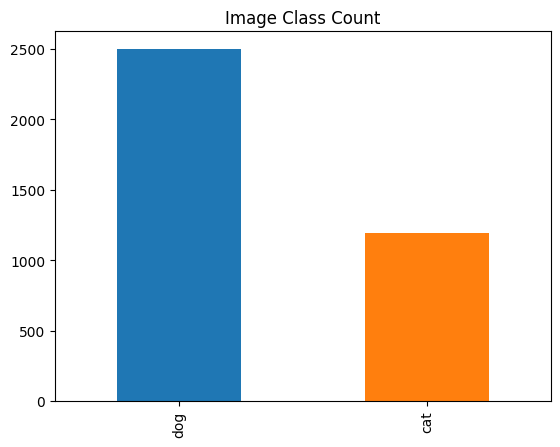

In [13]:
# Кол-во изображений с кошками и собаками. Как видно кол-во изображений несбалансированно по классам.
df.name.value_counts().plot(kind='bar', color=['tab:blue', 'tab:orange'])
plt.title('Image Class Count')
plt.show()

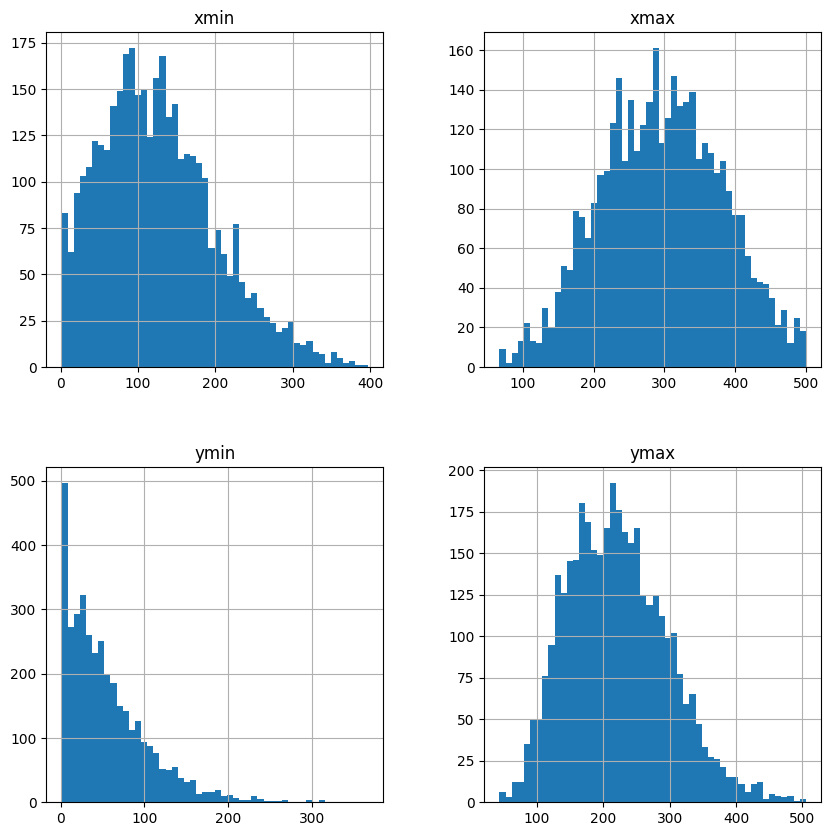

In [14]:
# Значения координат по всем изображениям
df[['xmin', 'xmax', 'ymin', 'ymax']].hist(bins=50, figsize=(10,10))
plt.show()

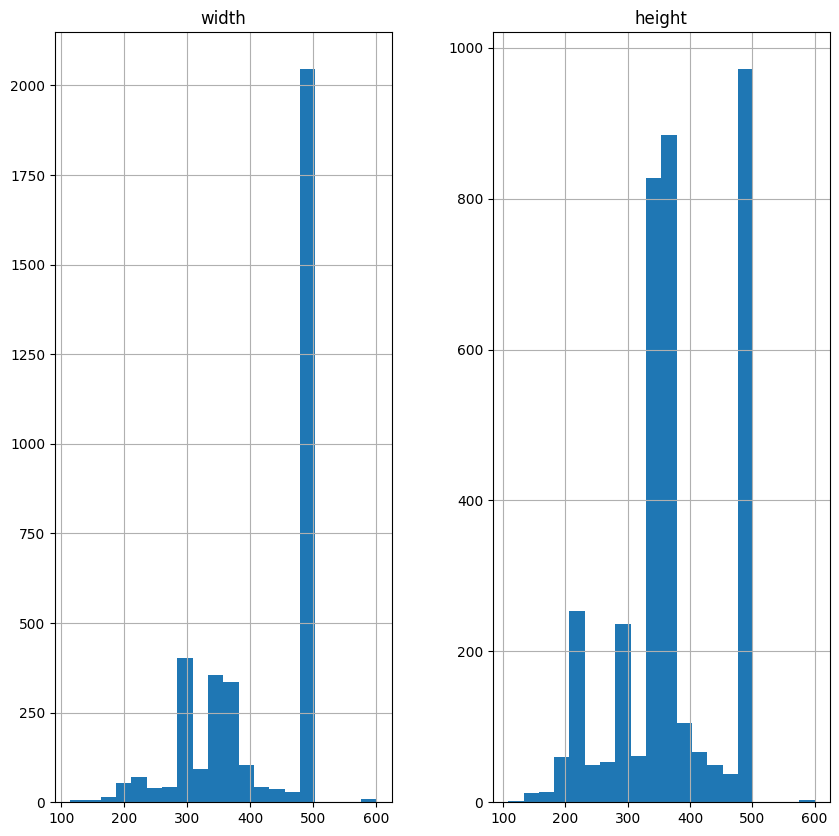

In [15]:
# Значения высоты и ширины по всем изображениям.
# Как видно картинки довольны сильно разнятся по высоте
df[['width', 'height']].hist(bins=20, figsize=(10,10))
plt.show()

In [16]:
image_folder = '/content/suft/images'

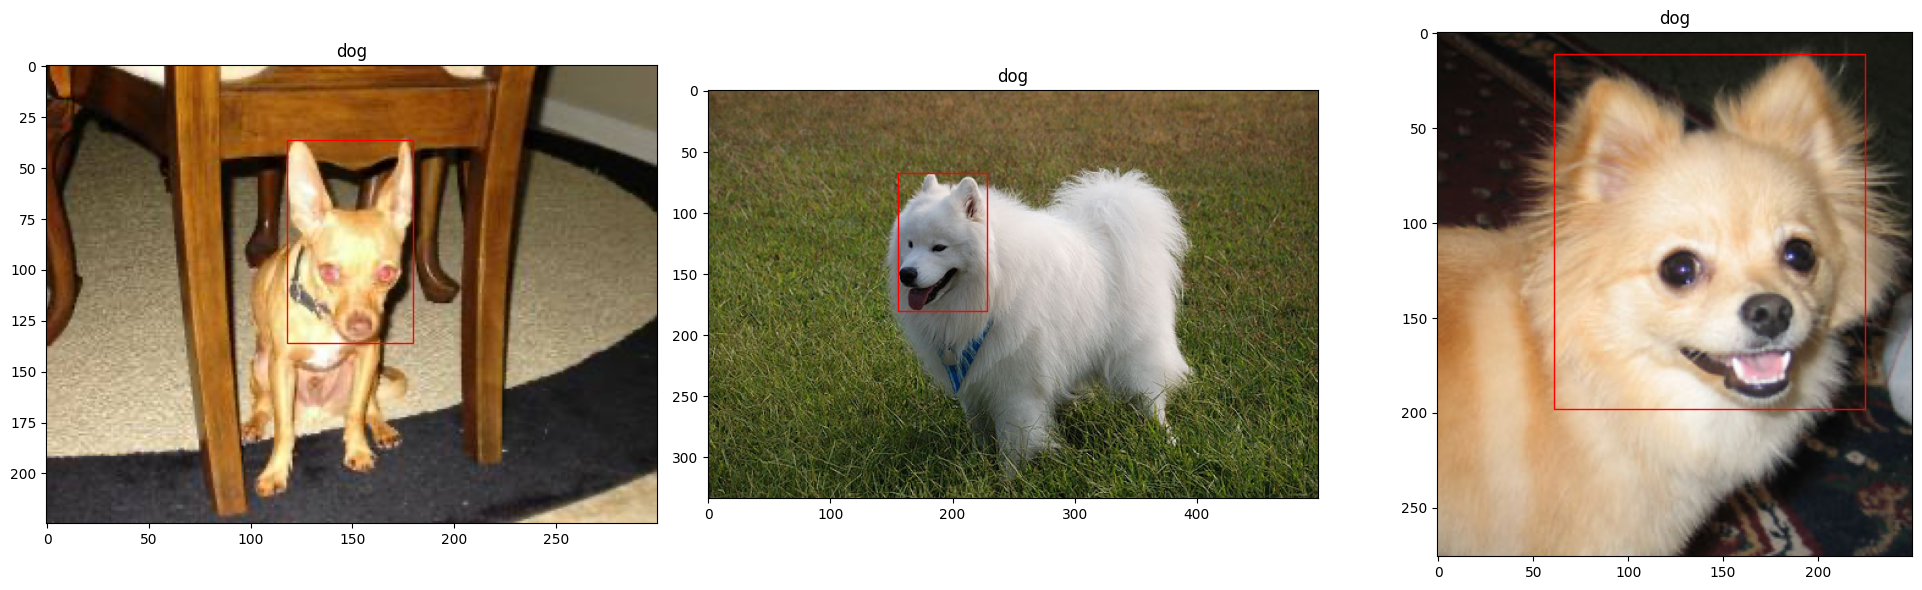

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i, j in enumerate(np.random.choice(df.shape[0], size=3, replace=False)):
    target_filename = image_folder + '/Cats_Test' + str(j) + '.png'
    target_filename1 = 'Cats_Test' + str(j) + '.png'
    img = mpimg.imread(target_filename)
    h, w = img.shape[:2]
    row_index = df[df['filename'] == target_filename1].index[0]
    coords = df.loc[row_index, ['xmin', 'ymin', 'xmax', 'ymax']]

    ax[i].imshow(img)
    ax[i].set_title(df.name[j])
    ax[i].add_patch(plt.Rectangle((coords[0], coords[1]),
                                  coords[2] - coords[0], coords[3] - coords[1],
                                  edgecolor='red', facecolor='none'))

plt.tight_layout()
plt.show()

### 4. Предобработка данных

 Чтобы обучить нейросеть на этих данных, нужно написать генератор батчей. Однако если будем подавать изображения так, как они есть, то даже батч собрать не сможем -- нужно привести их к однмоу размеру. Далее нужно привести их к типу float, переместить на CUDA и поделить значения в пикселях на 255. Также нужно настроить аугментации и постобработку.


In [18]:
class Aug_Dataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width

        self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-4:] == '.png']
        self.classes = ['cat', 'dog']

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res /= 255.0

        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)

        boxes = []
        labels = []

        tree = et.parse(annot_file_path)
        root = tree.getroot()

        wt = img.shape[1]
        ht = img.shape[0]

        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))

            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)

            xmin_corr = (xmin / wt) * self.width
            xmax_corr = (xmax / wt) * self.width
            ymin_corr = (ymin / ht) * self.height
            ymax_corr = (ymax / ht) * self.height

            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels
        }

        if self.transforms:
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [19]:
# Функция для визуализации картинок
def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    if isinstance(img, torch.Tensor):
        img = transforms.ToPILImage()(img).convert('RGB')
    a.imshow(img)

    boxes = target['boxes']
    if isinstance(boxes, torch.Tensor):
        boxes = boxes.tolist()

    for box in (boxes):
        x, y, width, height = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')
        a.add_patch(rect)

    plt.show()

In [20]:
def get_transform(train):
    if train:
        return A.Compose([
            A.HorizontalFlip(0.5),
            A.RandomBrightness(limit=0.2, p=1.0),
            A.Rotate(limit=50, p=1.0),
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2,
                                     val_shift_limit=0.2, p=0.9),
            ToTensorV2(p=1.0)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
            ToTensorV2(p=1.0)
        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [21]:
def get_model(num_classes, modelName):

    if modelName == 'fasterrcnn':
        model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

    if modelName == 'SSD_300':
        model = ssd300_vgg16(pretrained = True)
        from torchvision.models.detection.ssd import SSDClassificationHead
        anchors = model.anchor_generator.num_anchors_per_location()
        out_channels = [512, 1024, 512, 256, 256, 256]
        model.head.classification_head = SSDClassificationHead(out_channels, anchors, num_classes)
        return model

def collate_fn(batch):
    return tuple(zip(*batch))

Так как в датасете неравное кол-во изображений по каждому классу, то необходимо произвести аугментацию данных для класса 'cats', для того чтобы модель не переобучалась на класс 'dogs'

In [ ]:
# !rm -r new_cats
# !rm -r suft
# !rm -r all

In [22]:
# Папка с исходными изображениями и XML-файлами
source_image_dir = '/content/suft/images'
source_xml_dir = '/content/suft/annotations'

# Папка, в которой будут сохранены выбранные изображения и XML-файлы с кошками
destination_dir = 'new_cats'
os.makedirs(destination_dir, exist_ok=True)

image_files = [f for f in os.listdir(source_image_dir) if f.endswith('.png')]

def has_cat_annotation(xml_file):
    tree = et.parse(xml_file)
    root = tree.getroot()
    for member in root.findall('object'):
        if member.find('name').text.lower() == 'cat':
            return True
    return False

# Выбор изображений с кошками на основе наличия информации в XML-файлах
cat_image_files = [image_file for image_file in image_files if has_cat_annotation(os.path.join(source_xml_dir, image_file[:-4] + '.xml'))]

# Копируем выбранные изображения и соответствующие XML-файлы в папку с кошками
for cat_image in cat_image_files:
    source_image_path = os.path.join(source_image_dir, cat_image)
    destination_image_path = os.path.join(destination_dir, cat_image)
    shutil.copyfile(source_image_path, destination_image_path)

    xml_filename = cat_image[:-4] + '.xml'
    source_xml_path = os.path.join(source_xml_dir, xml_filename)
    destination_xml_path = os.path.join(destination_dir, xml_filename)
    shutil.copyfile(source_xml_path, destination_xml_path)

print(f"Скопировано {len(cat_image_files)} изображений и соответствующих XML-файлов с кошками в папку '{destination_dir}'.")


Скопировано 1188 изображений и соответствующих XML-файлов с кошками в папку 'new_cats'.


In [23]:
# размеры изображений
width, height = 256, 256

# Создается аугментированный датасет
cat_dataset = Aug_Dataset(destination_dir, width, height, transforms=get_transform(train=True))

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [24]:
print('length of dataset = ', len(cat_dataset), '\n')

length of dataset =  1188 



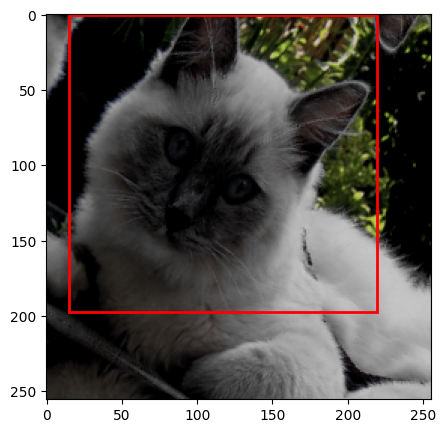

In [25]:
img, target = cat_dataset[50]
plot_img_bbox(img, target)

In [26]:
# Пути к папкам с изображениями и описаниями
images_dir = '/content/suft/images'
annotations_dir = '/content/suft/annotations'

# Папка, в которую будут объединены изображения и описания
combined_dir = 'all'

# Список файлов из папок
image_files = [f for f in os.listdir(images_dir) if f.endswith('.png')]
annotation_files = [f for f in os.listdir(annotations_dir) if f.endswith('.xml')]

# Создается папка для объединенных файлов, если она не существует
if not os.path.exists(combined_dir):
    os.makedirs(combined_dir)

# Создается словарь, где ключ - индекс после 'test', значение - пара файлов (изображение и описание)
combined_files = {}

# Группировка файлов по индексам
for image_file in image_files:
    index = int(image_file.split('Cats_Test')[1].split('.')[0])
    combined_files[index] = (os.path.join(images_dir, image_file), None)

for annotation_file in annotation_files:
    index = int(annotation_file.split('Cats_Test')[1].split('.')[0])
    if index in combined_files:
        combined_files[index] = (combined_files[index][0], os.path.join(annotations_dir, annotation_file))


# Объединение файлов в одну папку
for index, (image_path, annotation_path) in combined_files.items():
    if annotation_path:
        combined_image_path = os.path.join(combined_dir, os.path.basename(image_path))
        combined_annotation_path = os.path.join(combined_dir, os.path.basename(annotation_path))

        shutil.copy(image_path, combined_image_path)
        shutil.copy(annotation_path, combined_annotation_path)
    else:
        print(f"Не найдено соответствующее описание для изображения {image_path}")

print("Изображения и описания успешно объединены по индексам.")

Изображения и описания успешно объединены по индексам.


In [27]:
# Путь к папке, в которой находятся объединенные файлы
combined_dir = 'all'

# Список файлов в папке
combined_files = os.listdir(combined_dir)

# Количество файлов
file_count = len(combined_files)

print(f"Количество файлов в папке 'all': {file_count}")

Количество файлов в папке 'all': 7372


In [28]:
all_dataset = Aug_Dataset(combined_dir, width, height, transforms=get_transform(train=False))

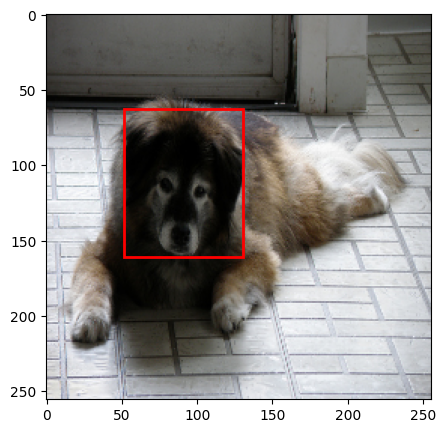

In [29]:
img, target = all_dataset[100]
plot_img_bbox(img, target)

In [32]:
def form_test(dataset):
  train_data, val_data = train_test_split(dataset, test_size=0.1, random_state=101)

  test_loader = torch.utils.data.DataLoader(
      val_data, batch_size=5, shuffle=False, num_workers=2,
      collate_fn=collate_fn)

  return test_loader

In [33]:
val = form_test(all_dataset)

In [34]:
from torch.utils.data import ConcatDataset, DataLoader, random_split

# Объединение cat_dataset и all_dataset в один датасет
combined_dataset = ConcatDataset([cat_dataset, all_dataset])

In [35]:
def form_loader(dataset):
  train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=101)

  train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=5, shuffle=True, num_workers=2,
    collate_fn=collate_fn)

  return train_loader

In [36]:
train = form_loader(combined_dataset)

### 5. Обучение моделей-детекторов


#### FASTER_RCNN training

In [38]:
n_batches, n_batches_test = len(train), len(val)

In [39]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
modelName = 'fasterrcnn'
model_RCNN = get_model(num_classes, modelName)
model_RCNN.to(device)
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_RCNN.parameters(), lr=learning_rate, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
def train_model(model, data_loader=None,val_loader=None, num_epoch=10):
    metric = MeanAveragePrecision()
    loss_accum_list = []
    map_list = []
    for epoch in range(1, num_epoch + 1):
        print(f"Starting epoch {epoch} of {num_epoch}")
        # time_start = time.time()
        loss_accum = 0.0
        model.train()

        for batch_idx, (images, targets) in enumerate(data_loader, 1):
            # Predict
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging
            loss_accum += loss.item()

        lr_scheduler.step()

        # Train losses
        train_loss = loss_accum / n_batches
        loss_accum_list.append(train_loss)

        # elapsed = time.time() - time_start
        # torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
        prefix = f"[Epoch {epoch:2d} / {num_epoch:2d}]"
        print(f"{prefix} Train loss: {train_loss:7.3f}", end=' | ')

        preds_single = []
        targets_single = []

        for batch_idx, (images, targets) in enumerate(val_loader, 1):

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            targets_single.extend(targets)

            model.eval()
            with torch.no_grad():
                pred = model(images)

            preds_single.extend(pred)

        metric.update(preds_single, targets_single)
        batch_map = metric.compute()
        map_list.append(batch_map['map'])
        print(f"Val mAP: {batch_map['map']}")

    return model, loss_accum_list, map_list

In [41]:
def plot_history(train_loss, map_list):
    plt.figure(figsize=(16,9))
    plt.grid(True)
    plt.plot(train_loss, label='Train loss')
    plt.plot(map_list, label='map_list')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [42]:
num_epoch = 5
model_RCNN, train_loss_RCNN, map_list_RCNN = train_model(model_RCNN, train, val, num_epoch)

Starting epoch 1 of 5
[Epoch  1 /  5] Train loss:   0.081 | Val mAP: 0.29110774397850037
Starting epoch 2 of 5
[Epoch  2 /  5] Train loss:   0.066 | Val mAP: 0.28400570154190063
Starting epoch 3 of 5
[Epoch  3 /  5] Train loss:   0.064 | Val mAP: 0.2732340693473816
Starting epoch 4 of 5
[Epoch  4 /  5] Train loss:   0.046 | Val mAP: 0.29706743359565735
Starting epoch 5 of 5
[Epoch  5 /  5] Train loss:   0.039 | Val mAP: 0.31157559156417847


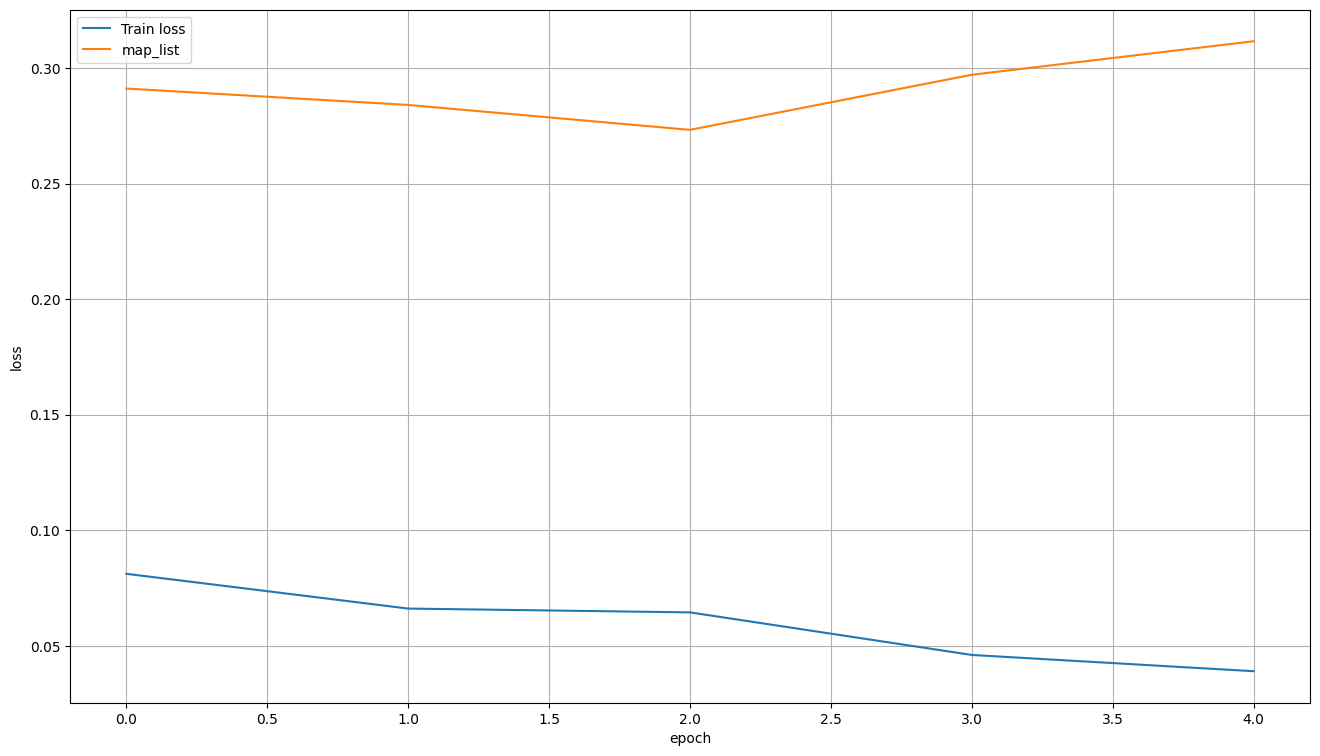

In [43]:
plot_history(train_loss_RCNN, map_list_RCNN)

In [44]:
def metric_test(model, test_loader):
    metric = MeanAveragePrecision()

    preds_single = []
    targets_single = []

    for batch_idx, (images, targets) in enumerate(test_loader, 1):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        targets_single.extend(targets)

        model.eval()
        with torch.no_grad():
            pred = model(images)

        preds_single.extend(pred)

    metric.update(preds_single, targets_single)
    test_map = metric.compute()

    print(f"Test mAP: {test_map['map']}")

In [45]:
metric_test(model_RCNN, val)

Test mAP: 0.362277626991272


### Предсказание IOU для одной картинки

In [51]:
def apply_threshold(prediction,threshold=0.15):
    index = prediction['scores'] > threshold
    pred = prediction.copy()
    pred['boxes'] = pred['boxes'][index]
    pred['scores'] = pred['scores'][index]
    pred['labels'] = pred['labels'][index]

    return pred

def apply_threshold_batch(prediction,threshold=0.15 ):
    preds = []

    for data in prediction:
        preds.append(apply_threshold(data, threshold))

    return preds

In [52]:
def plot_custom_img_bbox(image, prediction, target, class_labels):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(5, 5)

    if isinstance(image, torch.Tensor):
        image = transforms.ToPILImage()(image.cpu()).convert('RGB')

    ax.imshow(image)

    # Отрисовка предсказанных ограничивающих рамок
    pred_boxes = prediction['boxes'].cpu().detach().numpy()
    pred_labels = prediction['labels'].cpu().detach().numpy()
    for box, label_idx in zip(pred_boxes, pred_labels):
        x1, y1, x2, y2 = box
        label = class_labels[label_idx.item()]  # Преобразуем тензор метки в скаляр
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none', label=f'Predicted {label}')
        ax.add_patch(rect)
        ax.text(x1, y1, label, color='r', backgroundcolor='none', fontsize=12)

    # Отрисовка действительных ограничивающих рамок (из целевых данных)
    true_boxes = target['boxes'].cpu().detach().numpy()
    true_labels = target['labels'].cpu().detach().numpy()
    for box, label_idx in zip(true_boxes, true_labels):
        x1, y1, x2, y2 = box
        label = class_labels[label_idx.item()]  # Преобразуем тензор метки в скаляр
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='g', facecolor='none', label=f'True {label}')
        ax.add_patch(rect)

    plt.show()

In [53]:
def calculate_iou(box1, box2):
    # box1 и box2 представлены в формате [x1, y1, x2, y2], где (x1, y1) - левый верхний угол, (x2, y2) - правый нижний угол
    # Площадь ограничивающей рамки box1
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])

    # Площадь ограничивающей рамки box2
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Находим координаты области пересечения
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Проверка на пересечение
    if x1 < x2 and y1 < y2:
        # Площадь области пересечения
        intersection_area = (x2 - x1) * (y2 - y1)
        # IoU
        iou = intersection_area / (area1 + area2 - intersection_area)
        return iou
    else:
        return 0.0

In [54]:
def iou_func(targets, filtered_preds, i):
    # Инициализируем список для хранения значений IoU
    iou_values = []

    # Перебираем все действительные ограничивающие рамки
    for true_box in targets[i]['boxes'].cpu().detach().numpy():
        max_iou = 0  # Инициализируем максимальное значение IoU для данной действительной рамки
        for pred_box in filtered_preds[i]['boxes'].cpu().detach().numpy():
            iou = calculate_iou(pred_box, true_box)
            max_iou = max(max_iou, iou)  # Обновляем максимальное значение IoU
        iou_values.append(max_iou)  # Добавляем максимальное значение IoU

    # Вычисляем среднее значение IoU только для ненулевых значений
    average_iou = sum(iou_values) / len(iou_values)
    return average_iou

In [55]:
def calculate_precision_recall(tp, fp, fn):
    precision = tp / (tp + fp + 1e-6)  # Добавлено 1e-6 для избежания деления на ноль
    recall = tp / (tp + fn + 1e-6)
    return precision, recall

In [56]:
def calculate_tp_fp_fn(model, iou_threshold=0.5):
    tp = 0
    fp = 0
    fn = 0
    total_objects = 0

    for i, (image, target) in enumerate(val, 1):
        # Преобразование изображения и целевой информации на устройство
        image = list(img.to(device) for img in image)
        target = [{k: v.to(device) for k, v in t.items()} for t in target]

        # Получение предсказаний модели
        with torch.no_grad():
            pred = model(image)
            pred = apply_threshold_batch(pred, threshold=0.5)

        # Итерация по предсказаниям и целям
        for j, prediction in enumerate(pred):
            # Истинные ограничивающие рамки и метки
            true_boxes = target[j]['boxes'].cpu().detach().numpy()
            true_labels = target[j]['labels'].cpu().detach().numpy()

            # Предсказанные ограничивающие рамки, метки и оценки
            pred_boxes = prediction['boxes'].cpu().detach().numpy()
            pred_labels = prediction['labels'].cpu().detach().numpy()
            pred_scores = prediction['scores'].cpu().detach().numpy()

            # Создание массива булевых значений, где True, если IoU > порога
            iou_matrix = np.zeros((len(true_boxes), len(pred_boxes)), dtype=bool)
            for true_idx, true_box in enumerate(true_boxes):
                for pred_idx, pred_box in enumerate(pred_boxes):
                    iou = calculate_iou(true_box, pred_box)
                    iou_matrix[true_idx, pred_idx] = iou > iou_threshold

            # Вычисление TP и FP
            used_preds = set()  # Хранит индексы предсказаний, которые уже использованы как TP или FP
            for true_idx, true_label in enumerate(true_labels):
                for pred_idx, pred_label in enumerate(pred_labels):
                    if iou_matrix[true_idx, pred_idx] and true_label == pred_label and true_idx not in used_preds:
                        tp += 1
                        used_preds.add(true_idx)

                    elif iou_matrix[true_idx, pred_idx] and true_label != pred_label and true_idx not in used_preds:
                        fp += 1
                        used_preds.add(true_idx)

            total_objects += len(target[j]['labels'])
            # Вычисление FN
            fn = total_objects - fp- tp

    return tp, fp, fn

In [57]:
total_objects = 0

for images, targets in val:
    for target in targets:
        total_objects += len(target['labels'])

print(f"Общее количество объектов в тестовой выборке: {total_objects}")

Общее количество объектов в тестовой выборке: 369


In [58]:
# Пример использования:
# Замените last_batch на фактический батч данных из вашего test_loader_RCNN.
tp, fp, fn = calculate_tp_fp_fn(model_RCNN, iou_threshold=0.75)

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"Sum: {tp+fp+fn}")


True Positives (TP): 220
False Positives (FP): 14
False Negatives (FN): 135
Sum: 369


In [59]:
precision, recall = calculate_precision_recall(tp, fp, fn)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Precision: 0.9402
Recall: 0.6197


In [60]:
num_images = len(val.dataset)
print(f"Количество картинок в test_loader_RCNN: {num_images}")

Количество картинок в test_loader_RCNN: 369


In [66]:
def mmm(model):
    aver = []
    count = 0
    # Итерация по данным из test_loader_RCNN
    for i, (image, target) in enumerate(val, 1):
        # Преобразование изображения и целевой информации на устройство
        image = list(img.to(device) for img in image)
        target = [{k: v.to(device) for k, v in t.items()} for t in target]
        # Получение предсказаний модели
        model.eval()
        with torch.no_grad():
            pred = model_RCNN(image)
            pred1 = apply_threshold_batch(pred, threshold=0.5)

        for j in range(2):
            # print('count', count)
            av = iou_func(target, pred1,j)
            aver.append(av)
            # plot_custom_img_bbox(image[j], pred1[j], target[j], train.class_labels)
            count += 1
    return aver

In [62]:
def iou_my(model, index):
    model.eval()
    image, target = val.dataset[index]
    pred = model([image.to(device)])
    iou_pred = apply_threshold_batch(pred, threshold=0.5)
    return image, iou_pred, target

In [67]:
from statistics import mode
aver = mmm(model_RCNN)
max_index = aver.index(max(aver))
min_index = aver.index(min(aver))
med_index = aver.index(mode(aver))

max_image, max_pred, max_target = iou_my(model_RCNN,max_index)
min_image, min_pred, min_target = iou_my(model_RCNN,min_index)
med_image, med_pred, med_target = iou_my(model_RCNN,med_index)

In [68]:
import seaborn as sns

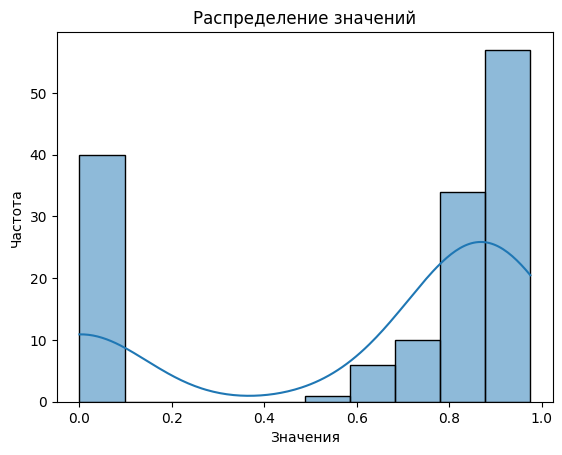

In [69]:
# Создайте распределение с помощью Seaborn
sns.histplot(aver, bins=10, kde=True)  # Вы можете настроить количество бинов (колонок) и отображение ядерной оценки плотности
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Распределение значений')
plt.show()

IOU - наибольшего значения 0.9751243591308594


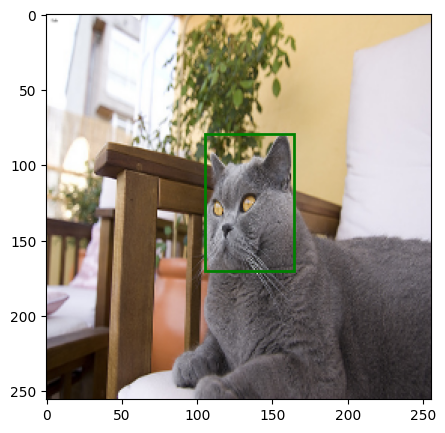

IOU - наименьшего значения 0.0


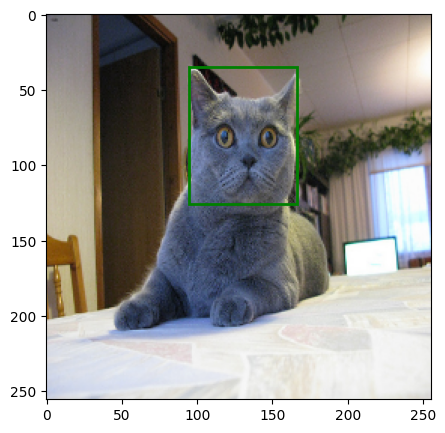

IOU - среднего значения 0.0


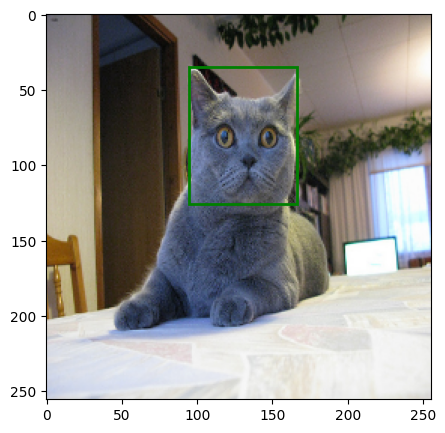

In [73]:
print('IOU - наибольшего значения', max(aver))
plot_custom_img_bbox(max_image, max_pred[0], max_target, cat_dataset.classes)

print('IOU - наименьшего значения', min(aver))
plot_custom_img_bbox(min_image, min_pred[0], min_target, cat_dataset.classes)

print('IOU - среднего значения', mode(aver))
plot_custom_img_bbox(med_image, med_pred[0], med_target, cat_dataset.classes)